this notebook if to verify that projections work correctly for both keypointnet data and occnet (real) data. the lines (in the 2nd image) should go through the point in the first image

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import tensorflow as tf
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../")
from data.occnet_data_loader import OccnetTfrecordLoader
from network.main import Transformer

In [2]:
sess = tf.Session()

In [3]:
vw, vh = 128, 128 # width, height

# set the dataset paths

In [4]:
OCCNET_DATASET_PATH = "../datasets/200/"
KEYPOINTNET_DATASET_PATH = "../../data/cars_with_keypoints/"

In [5]:
occnet_dataloader = OccnetTfrecordLoader(OCCNET_DATASET_PATH, occnet_data=True)
occnet_transformer = Transformer(128, 128, OCCNET_DATASET_PATH, occnet=True)
occnet_features = occnet_dataloader.get_features()
# features = sess.run(features)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


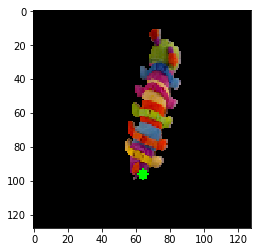

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


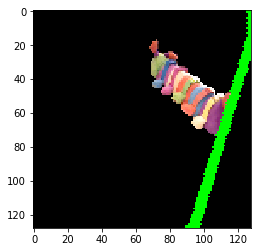

In [6]:
def func1(x):
    return tf.transpose(tf.reshape(occnet_features[x], [-1, 4, 4]), [0, 2, 1])

mv = [func1("mv%d" % i) for i in range(2)]
mvi = [func1("mvi%d" % i) for i in range(2)]
img0_depth = tf.reshape(occnet_features["img0_depth"], [-1, 480, 640])

u, v = -0.0, -0.5
points = []
for z in np.linspace(-0.5, 0.5, num=100):
    z_value = (img0_depth[0, 240, 320] / 1000.0) + z
    points.append([u, v, z_value])

# add back batch dimension
uvz = tf.expand_dims(tf.convert_to_tensor(points), axis=0)

world_coords = tf.matmul(occnet_transformer.unproject(uvz), mvi[0])
uvz_proj = occnet_transformer.project(tf.matmul(world_coords, mv[1 - 0]))

uvz, uvz_proj, img0, img1, img0_depth = sess.run(
    [
        uvz,
        uvz_proj,
        occnet_features["img0"][0, :, :, :3],
        occnet_features["img1"][0, :, :, :3],
        img0_depth
    ]
)

# draw on the image
x = (min(max(u, -1), 1) * vw / 2 + vw / 2) - 0.5
y = vh - 0.5 - (min(max(v, -1), 1) * vh / 2 + vh / 2)
if math.isnan(x) or math.isnan(y):
    pass
x = int(round(x))
y = int(round(y))
new_img0 = cv2.circle(img0.copy(), (x, y), 3, (0, 255, 0), -1)
plt.imshow(new_img0)
plt.show()

new_img1 = img1.copy()
for index, point in enumerate(uvz_proj[0]):
#     print(index)
#     print(point)
    try:
        u, v, z = point
        
#         x = int((u + 1.0) * 64.0)
#         y = 128 - int((v + 1.0) * 64.0)
        
        x = (min(max(u, -1), 1) * vw / 2 + vw / 2) - 0.5
        y = vh - 0.5 - (min(max(v, -1), 1) * vh / 2 + vh / 2)
        if math.isnan(x) or math.isnan(y):
            pass

        x = int(round(x))
        y = int(round(y))

        new_img1 = cv2.circle(new_img1, (x, y), 3, (0, 255, 0), -1)
    except:
        pass

plt.imshow(new_img1)
plt.show()

# plt.imshow(img0_depth[0])
# plt.show()


In [7]:
keypointnet_dataloader = OccnetTfrecordLoader(KEYPOINTNET_DATASET_PATH, occnet_data=False)
keypointnet_transformer = Transformer(128, 128, KEYPOINTNET_DATASET_PATH, occnet=False)
keypointnet_features = keypointnet_dataloader.get_features()
# keypointnet_features = sess.run(keypointnet_features)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


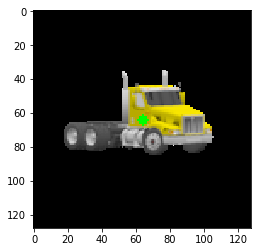

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


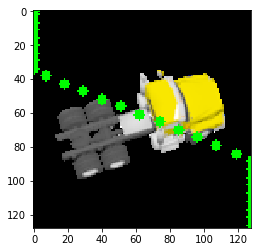

In [8]:
def func1(x):
    return tf.transpose(tf.reshape(keypointnet_features[x], [-1, 4, 4]), [0, 2, 1])

mv = [func1("mv%d" % i) for i in range(2)]
mvi = [func1("mvi%d" % i) for i in range(2)]

u, v = 0.0, 0.0
points = []
for z in np.linspace(-50.0, 0.0, num=200):
    points.append([u, v, z])
    
uvz = tf.constant([points])

world_coords = tf.matmul(keypointnet_transformer.unproject(uvz), mvi[0])
uvz_proj = keypointnet_transformer.project(tf.matmul(world_coords, mv[1 - 0]))

uvz, uvz_proj, img0, img1 = sess.run(
    [
        uvz,
        uvz_proj,
        keypointnet_features["img0"][0, :, :, :3],
        keypointnet_features["img1"][0, :, :, :3]
    ]
)

# draw on the image
x = int((u + 1.0) * 64.0)
y = int((v + 1.0) * 64.0)
new_img0 = cv2.circle(img0.copy(), (x, y), 3, (0, 255, 0), -1)
plt.imshow(new_img0)
plt.show()

new_img1 = img1.copy()
for index, point in enumerate(uvz_proj[0]):
#     print(index)
#     print(point)

    u, v, z = point
    # ---
#     x = int((u + 1.0) * 64.0)
#     y = 128 - int((v + 1.0) * 64.0)
    # OR
    x = (min(max(u, -1), 1) * vw / 2 + vw / 2) - 0.5
    y = vh - 0.5 - (min(max(v, -1), 1) * vh / 2 + vh / 2)
    x = int(round(x))
    y = int(round(y))
    
    new_img1 = cv2.circle(new_img1, (x, y), 3, (0, 255, 0), -1)

plt.imshow(new_img1)
plt.show()
